In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

- Creating Cheakcpoints

In [2]:
def create_model_checkpoint(experiment_name, dir_name="checkpoints",
                            save_freq='epoch', monitor = "val_accuracy"):

  checkpoint_dir = dir_name + "/" + experiment_name
  checkpoint_callback = ModelCheckpoint(
    checkpoint_dir, monitor=monitor, verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq=save_freq,
  )
  print(f"Saving model checkpoint to: {checkpoint_dir}")
  return checkpoint_callback

# Load data and split into training and test sets

In [20]:
train_df = pd.read_csv('/kaggle/input/pre-processed-data/train_preprocessed.csv')
test_df = pd.read_csv('/kaggle/input/pre-processed-data/test_preprocessed.csv')

In [21]:
train_df.head()

,keyword,location,text,target
0,neutral,us,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,fire,canada,Forest fire near La Ronge Sask Canada,1
2,evacuation,nowhere,All residents asked shelter place notified off...,1
3,evacuation,california,people receive wildfires evacuation orders Cal...,1
4,smoke,nowhere,Just got sent photo Ruby Alaska smoke wildfire...,1


- Now we will tokenize the text data and convert the text to sequences.

In [22]:
# find the text in train_df with the least number of words
min_words = train_df['text'].apply(lambda x: len(x.split(' '))).min()

In [53]:
text_tokenizer = tf.keras.layers.TextVectorization(max_tokens=5000, output_mode='int', output_sequence_length=8)

- This have converted text into numbers. 

- `max_tokens` is the number of words in the vocabulary.  (not necessarily these many words will be used) 
- `output_mode` is the type of output we want. Here we want to use the `one-hot` in the model so we will use `int`, which will give us the index of the word in the vocabulary.
- `output_sequence_length` is the length of the output sequence. It is the maximum length of the sentence in the data. We will pad the sentences which are shorter than this length and truncate the sentences which are longer than this length.
- `ngrams` is the number of words we want to consider when we tokenize the text. For example, if we have a sentence "I love deep learning", and `ngrams=2`, then the tokens will be `["I", "love", "deep", "learning", "I love", "love deep", "deep learning"]`. This will help us to capture the context of the words.

In [54]:
text_tokenizer.adapt(train_df["text"])

In [55]:
text_tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'i', 'the', 'a', 'like', 'amp', 'e', 's', 'fire']

In [56]:
# length of vocabulary
len(text_tokenizer.get_vocabulary())

5000

In [57]:
text_tokenizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 5000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 8,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

In [58]:
text_tokenizer("I love deep learning").numpy()

array([   2,   71, 1095, 1699,    0,    0,    0,    0])

In [59]:
test_df["text"][2:3]

2    forest fire spot pond geese fleeing across str...
Name: text, dtype: object

In [60]:
text_tokenizer(test_df["text"][2:3])

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[ 133,    9,  705, 2888,    1,    1,  799,  655]])>

In [61]:
train_df

,keyword,location,text,target
0,neutral,us,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,fire,canada,Forest fire near La Ronge Sask Canada,1
2,evacuation,nowhere,All residents asked shelter place notified off...,1
3,evacuation,california,people receive wildfires evacuation orders Cal...,1
4,smoke,nowhere,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...
7608,collapse,nowhere,Two giant cranes holding bridge collapse nearb...,1
7609,neutral,california,The control wild fires California even Norther...,1
7610,neutral,nowhere,M UTC km S Volcano Hawaii,1
7611,collided,nowhere,Police investigating ebike collided car Little...,1


In [62]:
# Split train and test set

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['target'], axis=1), train_df['target'], test_size=0.2, random_state=42)

# reshape y_train and y_test
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# convert to tensor
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [63]:
X_train.head()

,keyword,location,text
4996,military,texas,Courageous honest analysis need use Atomic Bom...
3263,engulfed,nowhere,wld b shame golf cart became engulfed flames b...
4907,massacre,cottonwood arizona,Tell rescind medals honor given US soldiers Ma...
2855,drought,"spokane, wa",Worried CA drought might affect Extreme Weathe...
4716,lava,"medan,indonesia",Lava Blast amp Power Red PantherAttack


In [71]:
# Embed a 10,000 word vocabulary into 128 dimensions
text_embedding = tf.keras.layers.Embedding(5000, 64)

In [72]:
text_embedding(text_tokenizer(X_train["text"][:5])).shape

TensorShape([5, 8, 64])

In [73]:
def conv_block(inputs, num_filters, kernel_size):
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

    return outputs

In [74]:
text = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

tokenized_ = text_tokenizer(text)

embedding = text_embedding(tokenized_)

x = conv_block(embedding, 64, 5)

x = conv_block(x, 128, 5)

x = conv_block(x, 256, 3)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)

x = tf.keras.layers.Dropout(0.7)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=text, outputs=outputs)

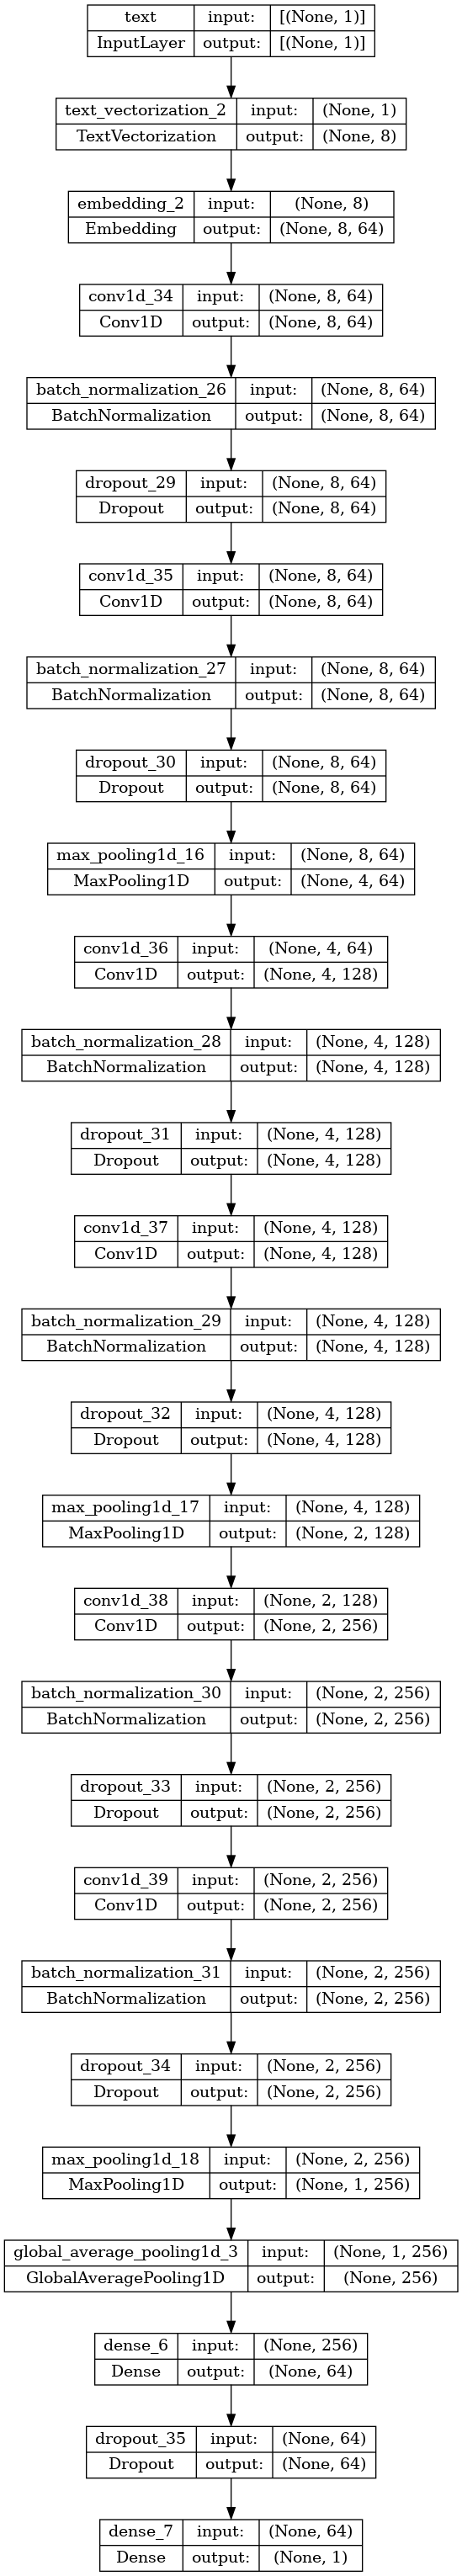

In [75]:

# Visualize model
tf.keras.utils.plot_model(model, show_shapes=True)


In [76]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

In [78]:
# Train model
history = model.fit(x=X_train["text"], y=y_train, epochs=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5744
Epoch 1: val_accuracy improved from -inf to 0.59882, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 10s 52ms/step - loss: 0.6870 - accuracy: 0.5744 - val_loss: 0.6586 - val_accuracy: 0.5988
Epoch 2/10
190/191 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.5850
Epoch 2: val_accuracy improved from 0.59882 to 0.61261, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 11s 60ms/step - loss: 0.6782 - accuracy: 0.5847 - val_loss: 0.6514 - val_accuracy: 0.6126
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.6046
Epoch 3: val_accuracy improved from 0.61261 to 0.61720, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 10s 54ms/step - loss: 0.6672 - accuracy: 0.604

- It is clearly overfitting, Let's try the Pre-Trained Embedding

# Pre-trained Embedings

- Load the Pre-trained Glove Embedding

In [79]:
import tensorflow_hub as hub
# We can use this encoding layer in place of our text_vectorizer and embedding layer
encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="Universal_Sentence_Encoder") 

In [85]:
def block(inputs, kernel, kernel_size=5):

    x = tf.keras.layers.Conv1D(kernel, 5)(inputs)
    x = tf.keras.layers.Conv1D(kernel, 5)(x)
    x = tf.keras.layers.MaxPool1D()(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x

In [96]:
text = tf.keras.layers.Input(shape=[], dtype=tf.string, name="text")

encoded_text = encoder_layer(text)

x = tf.keras.layers.Reshape(target_shape=(64, 8), input_shape=(512,))(encoded_text)

x = block(x, 64)

x = block(x, 128)

x = block(x, 256, 3)

# x = block(x, 128, 3)


output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs=[text], outputs=output)

# Compile model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

In [97]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 reshape_12 (Reshape)        (None, 64, 8)             0         
                                                                 
 conv1d_101 (Conv1D)         (None, 60, 64)            2624      
                                                                 
 conv1d_102 (Conv1D)         (None, 56, 64)            20544     
                                                                 
 max_pooling1d_46 (MaxPoolin  (None, 28, 64)           0         
 g1D)                                                      

In [99]:
# Train model
history_2 = model_2.fit(x=X_train["text"], y=y_train, epochs=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/10
190/191 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.5666
Epoch 1: val_accuracy improved from -inf to 0.57387, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 30s 130ms/step - loss: 0.8018 - accuracy: 0.5667 - val_loss: 0.6575 - val_accuracy: 0.5739
Epoch 2/10
190/191 [============================>.] - ETA: 0s - loss: 0.7008 - accuracy: 0.6507
Epoch 2: val_accuracy improved from 0.57387 to 0.58766, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 22s 117ms/step - loss: 0.7004 - accuracy: 0.6509 - val_loss: 0.6293 - val_accuracy: 0.5877
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6811
Epoch 3: val_accuracy improved from 0.58766 to 0.77413, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 24s 128ms/step - loss: 0.6614 - accuracy: 0.

- Training for more epochs

In [100]:
# Train model
history_3 = model_2.fit(x=X_train["text"], y=y_train, epochs=35, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/35
190/191 [============================>.] - ETA: 0s - loss: 0.5296 - accuracy: 0.7586
Epoch 2: val_accuracy improved from 0.80302 to 0.80630, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 23s 122ms/step - loss: 0.5300 - accuracy: 0.7586 - val_loss: 0.4537 - val_accuracy: 0.8063
Epoch 3/35
191/191 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.7594
Epoch 3: val_accuracy improved from 0.80630 to 0.81024, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 22s 115ms/step - loss: 0.5204 - accuracy: 0.7594 - val_loss: 0.4414 - val_accuracy: 0.8102
Epoch 4/35
191/191 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7563
Epoch 4: val_accuracy did not improve from 0.81024
191/191 [==============================] - 10s 53ms/step - loss: 0.5214 - accuracy: 0.7563 - val_loss: 0.4435 - val_accuracy: 0.8083
E

- Let's train for few more epochs

In [101]:
# Train model
history_4 = model_2.fit(x=X_train["text"], y=y_train, epochs=15, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/15
190/191 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8271
Epoch 1: val_accuracy improved from -inf to 0.82141, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 25s 130ms/step - loss: 0.4011 - accuracy: 0.8271 - val_loss: 0.4340 - val_accuracy: 0.8214
Epoch 2/15
190/191 [============================>.] - ETA: 0s - loss: 0.3994 - accuracy: 0.8258
Epoch 2: val_accuracy did not improve from 0.82141
191/191 [==============================] - 10s 54ms/step - loss: 0.3990 - accuracy: 0.8261 - val_loss: 0.4342 - val_accuracy: 0.8168
Epoch 3/15
190/191 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8245
Epoch 3: val_accuracy did not improve from 0.82141
191/191 [==============================] - 11s 55ms/step - loss: 0.3961 - accuracy: 0.8245 - val_loss: 0.4348 - val_accuracy: 0.8181
Epoch 4/15
190/191 [============================>.] - E

## Submit

In [103]:
# Predict on test set

y_pred = model_2.predict(test_df["text"])

102/102 [==============================] - 3s 14ms/step


In [104]:

y_pred.shape

(3263, 1, 1)

In [110]:
ids = pd.read_csv('/kaggle/input/test-id/test_id.csv')['id']

# merge ids and predictions
submission = pd.DataFrame(np.concatenate((ids.values.reshape(-1, 1), y_pred.reshape(-1,1)), axis=1), columns=['id', 'target'])

# make id int   
submission['id'] = submission['id'].astype('int')

# make target 0 and 1
submission['target'] = submission['target'].apply(lambda x: 0 if x < 0.5 else 1)

In [111]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [112]:
# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Submission using Pre-trained Embedding of Universal Sentence Encoder"

100%|██████████████████████████████████████| 22.2k/22.2k [00:05<00:00, 3.83kB/s]

Successfully submitted to Natural Language Processing with Disaster Tweets